- $x$: Fraction of Susceptible
- $y$: Fraction of Infected
- $z$: Fraction of Recovered and Dead

$$
\begin{align}
\dot{x} &= -\beta x y \\
\dot{y} &= \beta x y -\gamma y\\
\dot{z} &= \gamma y
\end{align}
$$


In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
sir_simulate <- function(beta, gamma, maxt=150, y0=1e-6, z0=0) {
  x0 <- 1 - y0 - z0
  x <- numeric(1+maxt)
  y <- numeric(1+maxt)
  z <- numeric(1+maxt)
  x[1] <- x0
  y[1] <- y0
  z[1] <- z0
  for (i in 1:maxt) {
    x[i+1] <- x[i] - beta*x[i]*y[i]
    y[i+1] <- y[i] + beta*x[i]*y[i] - gamma*y[i]
    z[i+1] <- z[i] + gamma*y[i]
  }
  data.frame(t=0:maxt, susceptible=x, infected=y, recovered=z)
}

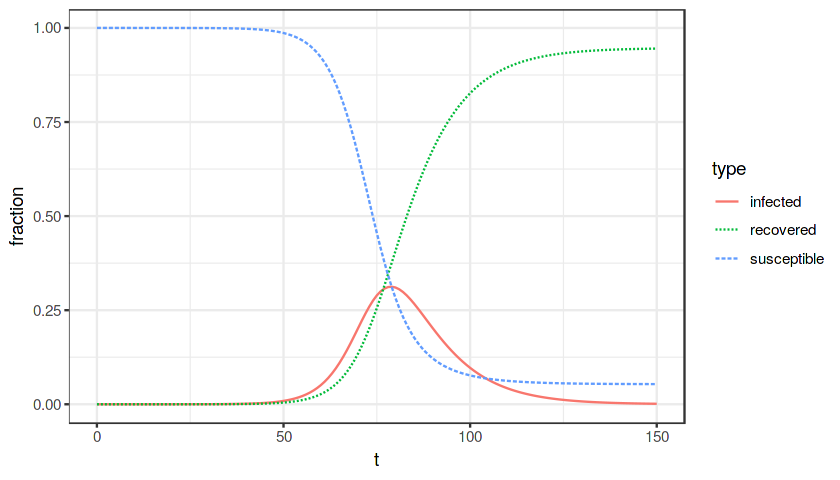

In [3]:
options(repr.plot.width=7, repr.plot.height=4)

simdata <- sir_simulate(0.3, 0.1)
pivot_longer(simdata, cols=-t, names_to="type", values_to="fraction") %>%
  ggplot(aes(t, fraction, color=type, linetype=type)) +
  geom_path() +
  #scale_y_log10() +
  theme_bw()

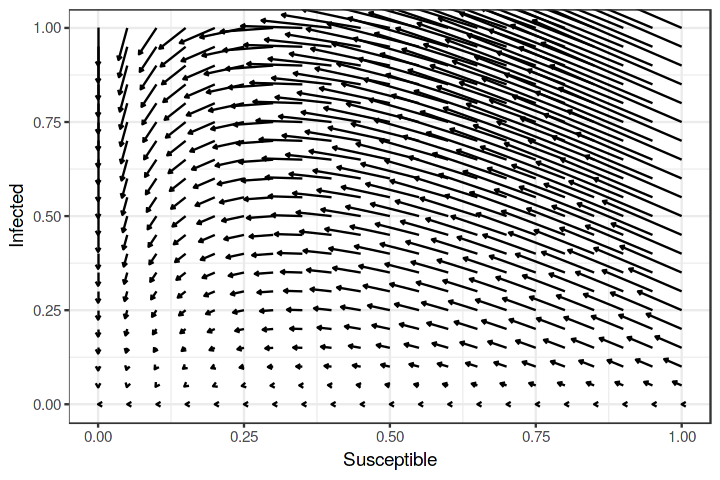

In [4]:
options(repr.plot.width=6, repr.plot.height=4)

sir_phase_diagram <- function(beta, gamma, ngrid=21, ...) {
  expand.grid(x=seq(0,1,length=ngrid), y=seq(0,1,length=ngrid)) %>%
    mutate(delta_x=-beta*x*y, delta_y=beta*x*y-gamma*y) %>%
  ggplot(aes(x, y, xend=x+delta_x, yend=y+delta_y)) +
    geom_segment(...) +
    xlab("Susceptible") + ylab("Infected") +
    coord_cartesian(xlim=c(0,1), ylim=c(0,1)) +
    theme_bw()
}
sir_phase_diagram(0.3, 0.1, arrow=arrow(length = unit(0.1,"cm")))

In [5]:
simulate_temporary_policy <- function(beta, gamma, t_policy, beta_policy, maxt=150, y0=1e-6, z0=0) {
  x0 <- 1 - y0 - z0
  x <- numeric(1+maxt)
  y <- numeric(1+maxt)
  z <- numeric(1+maxt)
  x[1] <- x0
  y[1] <- y0
  z[1] <- z0
  for (i in 1:maxt) {
    beta_ <- if (i %in% t_policy) beta_policy else beta
    x[i+1] <- x[i] - beta_*x[i]*y[i]
    y[i+1] <- y[i] + beta_*x[i]*y[i] - gamma*y[i]
    z[i+1] <- z[i] + gamma*y[i]
  }
  list(t=0:maxt, susceptible=x, infected=y, recovered=z) %>% as.data.frame()
}

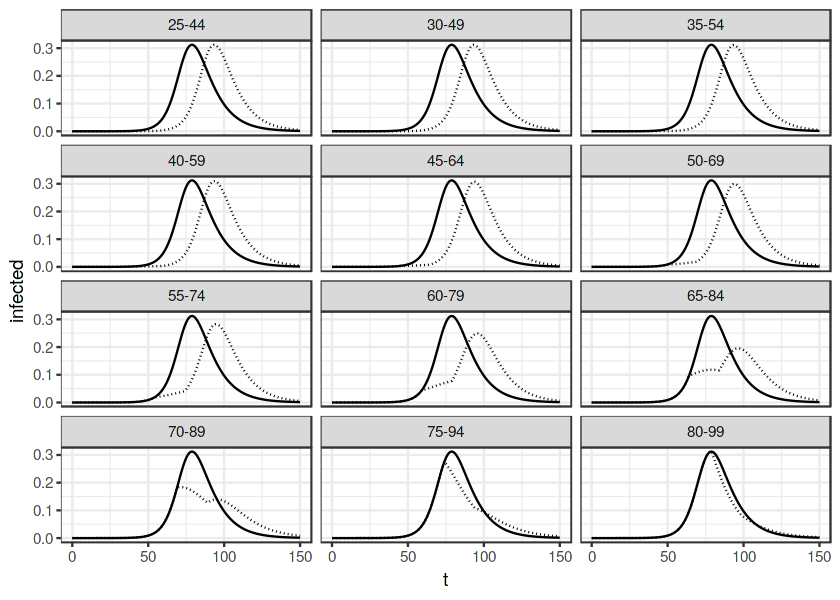

In [6]:
simdata_policy <- NULL
for (pstart in seq(25, 80, by=5)) {
  tmp <- simulate_temporary_policy(0.3, 0.1, pstart:(pstart+19), 0.15) %>%
    mutate(policy_period=sprintf("%d-%d", pstart, pstart+19))
  simdata_policy <- rbind(simdata_policy, tmp)  
}

options(repr.plot.width=7, repr.plot.height=5)
ggplot(simdata_policy, aes(t, infected)) +
  facet_wrap(vars(policy_period), ncol=3) +
  geom_line(linetype="dotted") +
  geom_line(aes(t, infected), data=simdata) +
  theme_bw()

70

Warning message:
“Removed 2 rows containing missing values (geom_path).”

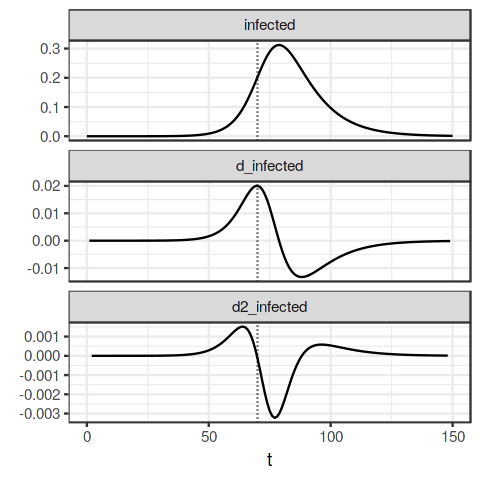

In [7]:
options(repr.plot.width=4, repr.plot.height=4)
tmp <- simdata %>%
  mutate(d_infected=(lead(infected) - lag(infected))/2,
         d2_infected=(lead(d_infected) - lag(d_infected))/2) %>%
  select(t, infected, d_infected, d2_infected) %>%
  pivot_longer(-t, names_to="variable", values_to="value") %>%
  mutate(variable=factor(variable, levels=c("infected", "d_infected", "d2_infected"))) 
inflection <- filter(tmp, variable=="d_infected") %>%
  arrange(desc(value)) %>%
  head(1) %>%
  select(t) %>%
  as.numeric()
cat(inflection)

ggplot(tmp, aes(t, value)) +
  geom_line() +
  geom_vline(xintercept=inflection, size=0.5, linetype="dotted") +
  facet_wrap(vars(variable), ncol=1, scale="free_y") +
  ylab(element_blank()) +
  theme_bw()

In [8]:
jpn <- read.csv("https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/detailByRegion.csv",
                stringsAsFactors=FALSE) %>%
  setNames(c("date", "pref", "confirmed", "hospitalized", "recovered", "dead")) %>%
  mutate(date=as.Date(as.character(date), format="%Y%m%d"))
head(jpn)
tail(jpn)

date,pref,confirmed,hospitalized,recovered,dead
<date>,<chr>,<int>,<int>,<int>,<int>
2020-03-19,北海道,153,77,69,7
2020-03-19,愛知県,123,106,3,14
2020-03-19,東京都,105,80,23,2
2020-03-19,大阪府,100,78,22,0
2020-03-19,兵庫県,69,66,0,3
2020-03-19,神奈川県,52,42,6,4


,date,pref,confirmed,hospitalized,recovered,dead
,<date>,<chr>,<int>,<int>,<int>,<int>
684,2020-04-04,佐賀県,4,4,0,0
685,2020-04-04,鹿児島県,3,3,0,0
686,2020-04-04,宮崎県,3,2,1,0
687,2020-04-04,徳島県,3,2,1,0
688,2020-04-04,香川県,2,2,0,0
689,2020-04-04,山形県,1,1,0,0



Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 6 rows containing missing values (geom_point).”`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

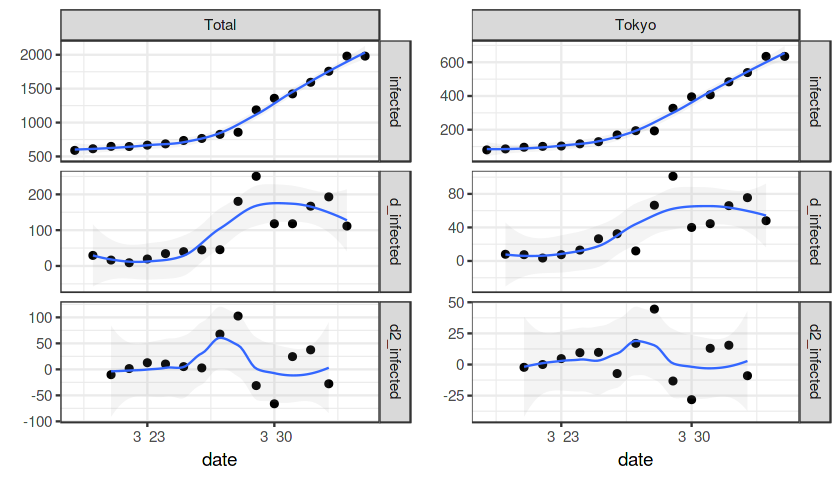

In [9]:
g1 <- mutate(jpn, infected=confirmed-recovered-dead) %>%
  group_by(date) %>%
  summarize(infected=sum(infected)) %>%
  ungroup() %>%
  mutate(pref="Total") %>%
  select(date, pref, infected) %>%
  mutate(d_infected=(lead(infected) - lag(infected))/2,
         d2_infected=(lead(d_infected) - lag(d_infected))/2) %>%
  pivot_longer(-c(pref, date), names_to="variable", values_to="value") %>%
  mutate(variable=factor(variable, levels=c("infected", "d_infected", "d2_infected"))) %>%
ggplot(aes(date, value)) +
  geom_point() +
  geom_smooth(size=0.5, alpha=0.1) +
  facet_grid(variable ~ pref, scales="free_y") +
  ylab(element_blank()) +
  theme_bw()
library(gridExtra)

g2 <- mutate(jpn, infected=confirmed-recovered-dead) %>%
  filter(pref=="東京都") %>%
  mutate(pref="Tokyo") %>%
  select(date, pref, infected) %>%
  mutate(d_infected=(lead(infected) - lag(infected))/2,
         d2_infected=(lead(d_infected) - lag(d_infected))/2) %>%
  pivot_longer(-c(pref, date), names_to="variable", values_to="value") %>%
  mutate(variable=factor(variable, levels=c("infected", "d_infected", "d2_infected"))) %>%
ggplot(aes(date, value)) +
  geom_point() +
  geom_smooth(size=0.5, alpha=0.1) +
  facet_grid(variable ~ pref, scales="free_y") +
  ylab(element_blank()) +
  theme_bw()

options(repr.plot.width=7, repr.plot.height=4)
grid.arrange(g1, g2, nrow=1)

Estimating equations:
$$
\begin{align}
z &= C -\rho \log x, \;\;\; \rho=\frac{\gamma}{\beta} \\
\frac{dz}{dt} &= \gamma y
f\end{align}
$$

In [10]:
estimate_sir_params <- function(x, y, z) {
  m1 <- lm(z ~ log(x))
  delta_z <- (lead(z) - lag(z))/2
  #delta_z <- (lead(z) - z)
  m2 <- lm(delta_z ~ y - 1)
  rho <- -m1$coef[2] %>% unname()
  gamma <- m2$coef[1] %>% unname()
  beta <- gamma / rho %>% unname()
  
  rho_se <- sqrt(diag(vcov(m1)))[2] %>% unname()
  gamma_se <- sqrt(diag(vcov(m2)))[1] %>% unname()
  beta_se <- sqrt(gamma_se^2 / rho^2 + rho_se^2 * (gamma/rho^2)^2) %>% unname()
  # assumes zero cross variance
  out <- list(beta=beta, gamma=gamma, rho=rho, 
              beta_se=beta_se, gamma_se=gamma_se, rho_se=rho_se,
              models=list(m1, m2))
  out
}

d <- sir_simulate(0.3, 0.1)
estimate_sir_params(d$susceptible, d$infected, d$recovered)

$beta
[1] 0.3098709

$gamma
[1] 0.09990712

$rho
[1] 0.3224153

$beta_se
[1] 0.0007799893

$gamma_se
[1] 0.0002503641

$rho_se
[1] 7.638358e-05

$models
$models[[1]]

Call:
lm(formula = z ~ log(x))

Coefficients:
(Intercept)       log(x)  
  0.0002112   -0.3224153  


$models[[2]]

Call:
lm(formula = delta_z ~ y - 1)

Coefficients:
      y  
0.09991  




In [11]:
# possiblity of estimation from partial data
ests <- NULL
for (start in seq(10, 130, by=10)) {
  tmp <- d[start:(start+19),]
  est <- estimate_sir_params(tmp$susceptible, tmp$infected, tmp$recovered)
  est <- as.data.frame(est[c("beta", "beta_se", "gamma", "gamma_se", "rho", "rho_se")])
  est$start <- start
  ests <- rbind(ests, est)
}

In [12]:
head(ests)

beta,beta_se,gamma,gamma_se,rho,rho_se,start
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2750067,3.808235e-07,0.09166796,1.093407e-07,0.3333299,2.344859e-07,10
0.2750414,2.356081e-06,0.09167470,6.765471e-07,0.3333123,1.449760e-06,20
0.2752553,1.451650e-05,0.09171617,4.171334e-06,0.3332040,8.896088e-06,30
0.2765312,8.721620e-05,0.09196419,2.516598e-05,0.3325635,5.214883e-05,40
0.2829293,4.547317e-04,0.09322198,1.338370e-04,0.3294886,2.380541e-04,50
0.2991943,1.369260e-03,0.09652610,4.215314e-04,0.3226201,4.415779e-04,60


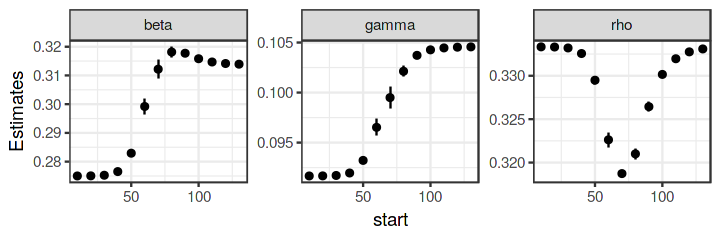

In [13]:
options(repr.plot.width=6, repr.plot.height=2)
pivot_longer(ests, -start, names_to="variable", values_to="value") %>%
  mutate(type=ifelse(grepl("_se", variable), "se", "estimate")) %>%
  mutate(variable=sub("_se", "", variable)) %>%
  pivot_wider(id_cols=c(start, variable), names_from=type, values_from=value) %>%
  mutate(lb=estimate-2*se, ub=estimate+2*se) %>%
ggplot(aes(start)) +
  geom_segment(aes(y=lb, yend=ub, xend=start)) +
  geom_point(aes(y=estimate)) +
  facet_wrap(vars(variable), scales="free_y") +
  ylab("Estimates") +
  theme_bw()

In [14]:
load_csse_data <- function() {
  y <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                stringsAsFactors=FALSE) %>%
    select(-c(Lat, Long)) %>%
    pivot_longer(-c(Province.State, Country.Region), names_to="date", values_to="confirmed") %>%
    mutate(date=as.Date(date, format="X%m.%d.%y"))
  z1 <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
                stringsAsFactors=FALSE) %>%
    select(-c(Lat, Long)) %>%
    pivot_longer(-c(Province.State, Country.Region), names_to="date", values_to="recovered") %>%
    mutate(date=as.Date(date, format="X%m.%d.%y"))
  z2 <- read.csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv",
                 stringsAsFactors=FALSE) %>%
    select(-c(Lat, Long)) %>%
    pivot_longer(-c(Province.State, Country.Region), names_to="date", values_to="dead") %>%
    mutate(date=as.Date(date, format="X%m.%d.%y"))

  inner_join(y, z1) %>% inner_join(z2) %>%
    rename(state=Province.State, country=Country.Region)
}
csse <- load_csse_data()
head(csse)

Joining, by = c("Province.State", "Country.Region", "date")
Joining, by = c("Province.State", "Country.Region", "date")


state,country,date,confirmed,recovered,dead
<chr>,<chr>,<date>,<int>,<int>,<int>
,Afghanistan,2020-01-22,0,0,0
,Afghanistan,2020-01-23,0,0,0
,Afghanistan,2020-01-24,0,0,0
,Afghanistan,2020-01-25,0,0,0
,Afghanistan,2020-01-26,0,0,0
,Afghanistan,2020-01-27,0,0,0


In [15]:
pop_world <- read.csv(text='country,pop
Italy,60243406
France,67076000
Germany,83149300
Spain,47100396
United Kingdom,66435550
US,329567756
Australia,25667395
Brazil,211345539
Japan,125950000', stringsAsFactors=FALSE)
pop_world

country,pop
<chr>,<int>
Italy,60243406
France,67076000
Germany,83149300
Spain,47100396
United Kingdom,66435550
US,329567756
Australia,25667395
Brazil,211345539
Japan,125950000


In [16]:
tmp <- group_by(csse, date, country) %>%
  summarize(confirmed=sum(confirmed),
            recovered=sum(recovered),
            dead=sum(dead)) 

world_data <- inner_join(pop_world, tmp) %>%
  mutate(infected=confirmed-recovered-dead,
         recovered_or_dead=recovered+dead,
         susceptible=pop-infected-recovered) %>%
  mutate(x=susceptible/pop, y=infected/pop, z=recovered_or_dead/pop)
head(world_data)

Joining, by = "country"


country,pop,date,confirmed,recovered,dead,infected,recovered_or_dead,susceptible,x,y,z
<chr>,<int>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Italy,60243406,2020-01-22,0,0,0,0,0,60243406,1,0,0
Italy,60243406,2020-01-23,0,0,0,0,0,60243406,1,0,0
Italy,60243406,2020-01-24,0,0,0,0,0,60243406,1,0,0
Italy,60243406,2020-01-25,0,0,0,0,0,60243406,1,0,0
Italy,60243406,2020-01-26,0,0,0,0,0,60243406,1,0,0
Italy,60243406,2020-01-27,0,0,0,0,0,60243406,1,0,0


Warning message:
“Transformation introduced infinite values in continuous y-axis”

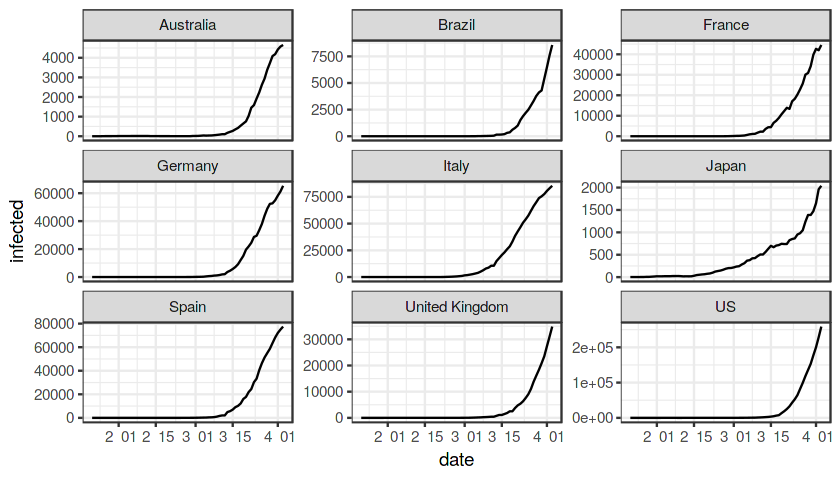

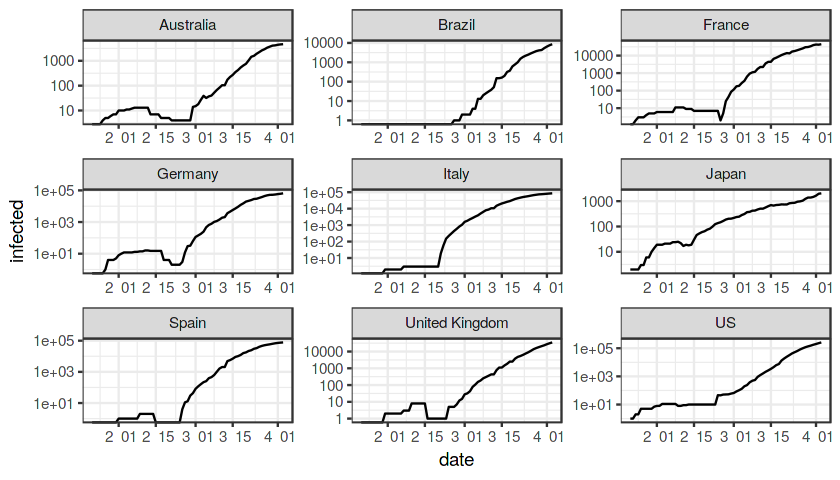

In [17]:
options(repr.plot.width=7, repr.plot.height=4)
ggplot(world_data, aes(date, infected)) +
  geom_line() +
  facet_wrap(vars(country), scales="free_y") +
  theme_bw()

ggplot(world_data, aes(date, infected)) +
  geom_line() +
  facet_wrap(vars(country), scale="free") +
  scale_y_log10() +
  theme_bw()

beta,beta_se,gamma,gamma_se,rho,rho_se,country
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.07907875,0.004384999,0.028134402,0.0012287606,0.35577700,0.012155607,Italy
0.14291186,0.011818936,0.051178439,0.0036351640,0.35811191,0.015169270,France
0.15150804,0.017094707,0.045571773,0.0039311656,0.30078783,0.021875687,Germany
0.14989493,0.009095075,0.057732641,0.0021924671,0.38515405,0.018226474,Spain
0.17628917,0.012118750,0.017681109,0.0009193179,0.10029606,0.004510277,United Kingdom
0.18031591,0.021056021,0.011400949,0.0011161479,0.06322764,0.004024576,US
0.15351706,0.022185938,0.015456542,0.0017601027,0.10068290,0.008959095,Australia
0.16341509,0.022251784,0.009835172,0.0012057114,0.06018521,0.003567096,Brazil
0.07657069,0.014315862,0.018860526,0.0032226017,0.24631523,0.018694400,Japan


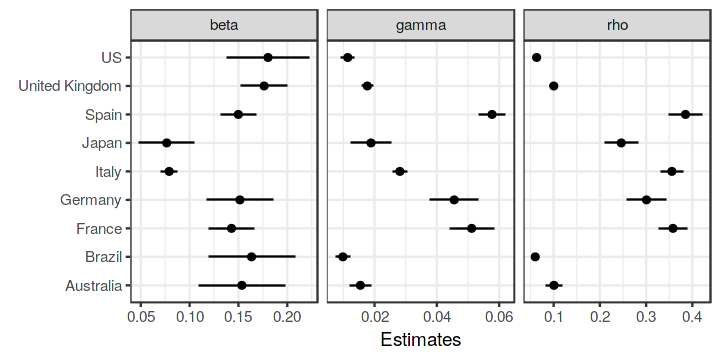

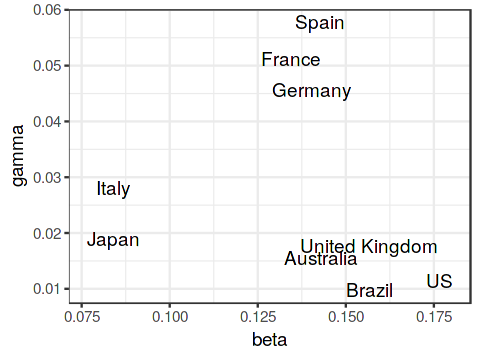

In [18]:
world_est <- NULL
for (ctr in unique(world_data$country)) {
  tmp <- filter(world_data, country==ctr) %>% 
    arrange(date) %>%
    tail(20)
  est <- estimate_sir_params(tmp$x, tmp$y, tmp$z)
  tmp <- as.data.frame(est[c("beta", "beta_se", "gamma", "gamma_se", "rho", "rho_se")])
  tmp$country <- ctr
  world_est <- rbind(world_est, tmp)                    
}
world_est

options(repr.plot.width=6, repr.plot.height=3)
pivot_longer(world_est, -country, names_to="variable", values_to="value") %>%
  mutate(type=ifelse(grepl("_se", variable), "se", "estimate")) %>%
  mutate(variable=sub("_se", "", variable)) %>%
  pivot_wider(id_cols=c(country, variable), names_from=type, values_from=value) %>%
  mutate(lb=estimate-2*se, ub=estimate+2*se) %>%
ggplot(aes(country)) +
  geom_segment(aes(y=lb, yend=ub, xend=country)) +
  geom_point(aes(y=estimate)) +
  facet_wrap(vars(variable), scales="free_x") +
  xlab(element_blank()) + ylab("Estimates") +
  coord_flip() +
  theme_bw()

options(repr.plot.width=4, repr.plot.height=3)
ggplot(world_est, aes(beta, gamma)) +
  geom_text(aes(label=country), hjust="inward") +
  theme_bw()

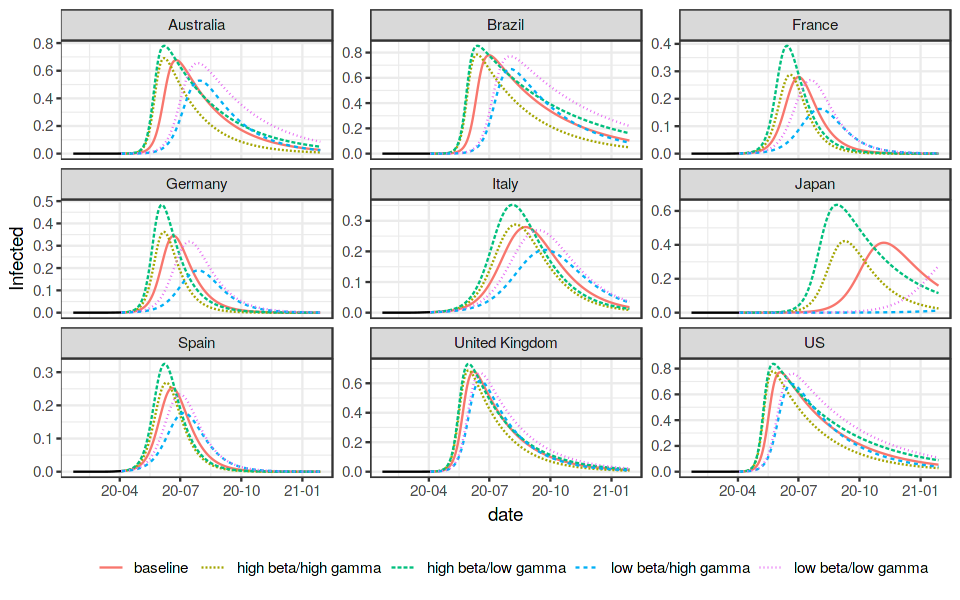

In [19]:
world_sim <- NULL
for (ctr in unique(world_data$country)) {
  start <- filter(world_data, country==ctr) %>% arrange(date) %>% tail(1)
  est <- filter(world_est, country==ctr)
  tmp1 <- sir_simulate(beta=est$beta, gamma=est$gamma,
                       y0=start$y, z0=start$z, maxt=300) %>%
    mutate(param="baseline")
  tmp2 <- sir_simulate(beta=est$beta-est$beta_se*2, gamma=est$gamma+est$gamma_se*2,
                       y0=start$y, z0=start$z, maxt=300) %>%
    mutate(param="low beta/high gamma")
  tmp3 <- sir_simulate(beta=est$beta+est$beta_se*2, gamma=est$gamma-est$gamma_se*2,
                       y0=start$y, z0=start$z, maxt=300) %>%
    mutate(param="high beta/low gamma")
  tmp4 <- sir_simulate(beta=est$beta+est$beta_se*2, gamma=est$gamma+est$gamma_se*2,
                       y0=start$y, z0=start$z, maxt=300) %>%
    mutate(param="high beta/high gamma")
  tmp5 <- sir_simulate(beta=est$beta-est$beta_se*2, gamma=est$gamma-est$gamma_se*2,
                       y0=start$y, z0=start$z, maxt=300) %>%
    mutate(param="low beta/low gamma")
  tmp <- rbind(tmp1, tmp2, tmp3, tmp4, tmp5)

  tmp$country <- ctr
  tmp$date <- start$date + tmp$t
  world_sim <- rbind(world_sim, tmp)                    
}

options(repr.plot.width=8, repr.plot.height=5)
ggplot(world_data, aes(date, y)) +
  geom_line() +
  geom_line(data=world_sim, aes(date, infected, color=param, linetype=param)) +
  facet_wrap(vars(country), scales="free_y", ncol=3) +
  ylab("Infected") +
  theme_bw() +
  scale_x_date(labels=date_format("%y-%m")) +
  theme(legend.position="bottom", legend.title=element_blank())